# Tutorial 5: Self-supervised learning for point clouds

## PointNet and PointNet++
PointNet is one of the early point cloud architectures. To get the representation of the point cloud, each point's coordinates are passed through MLP and then aggregated with permutation-invariant function (maximum in this case).

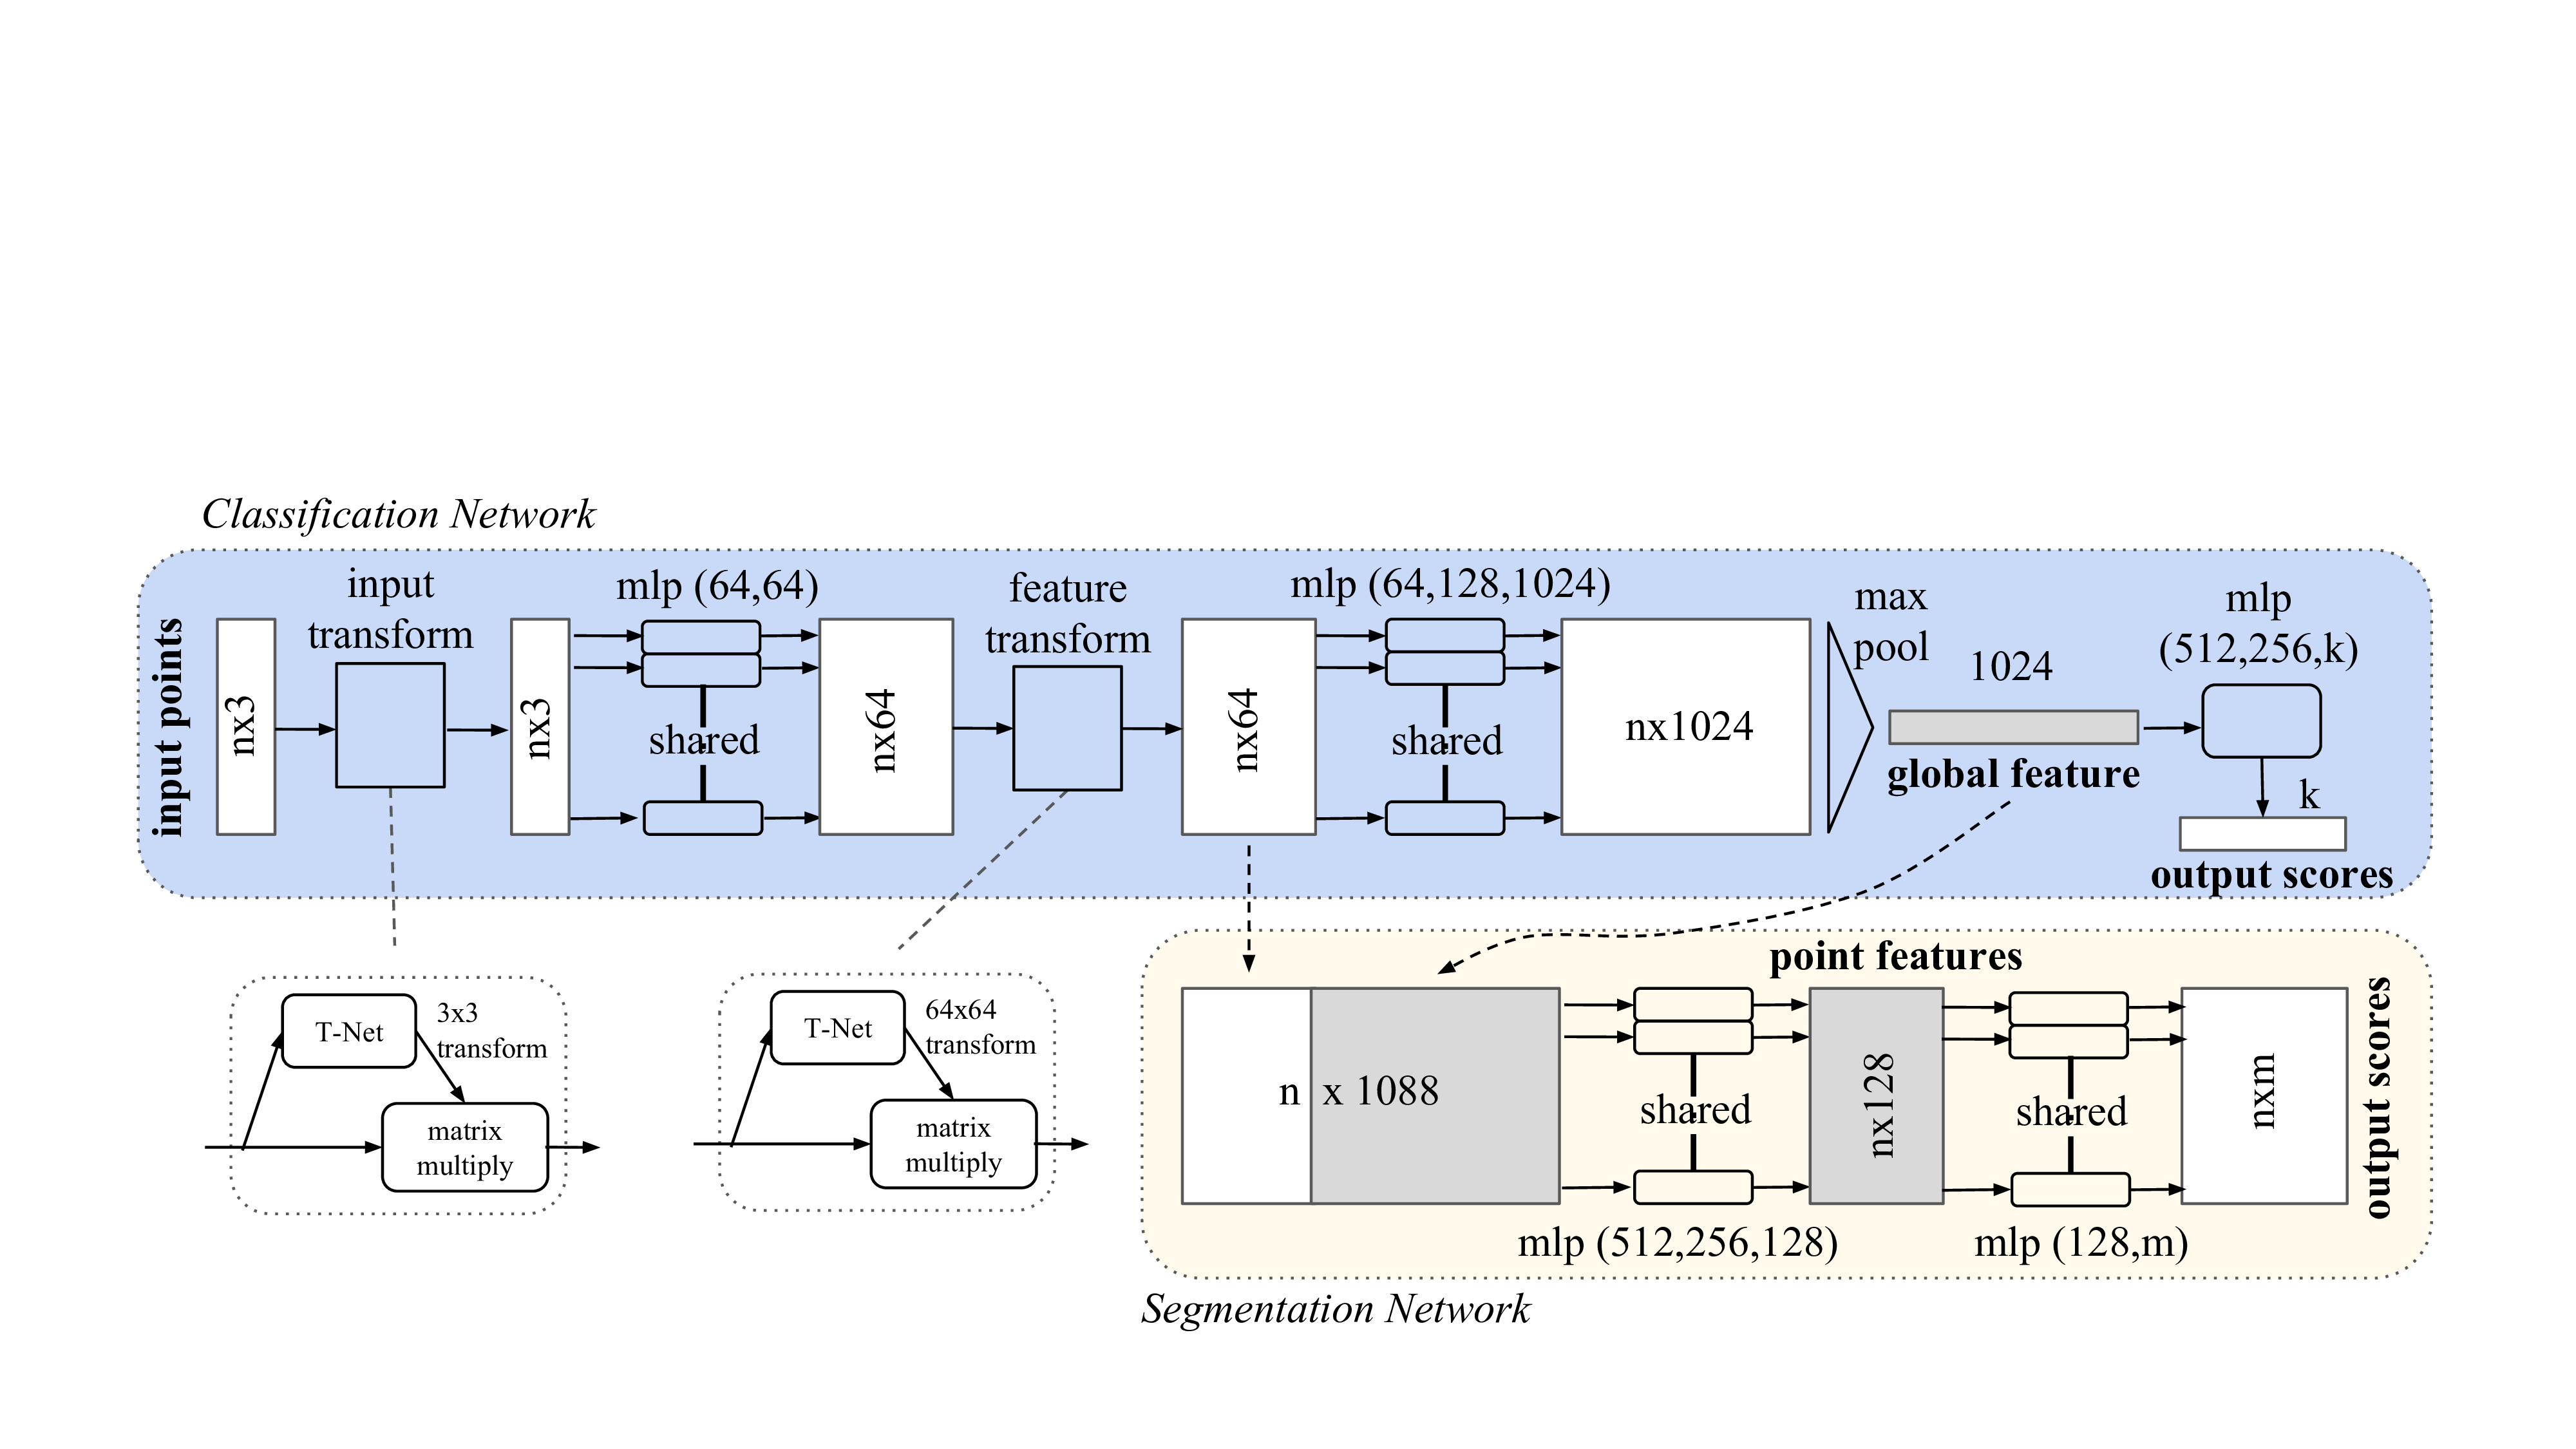

In [1]:
from wand.image import Image as WImage
img = WImage(filename='figures/pointnet_fixed.pdf', resolution=400)
img

In [2]:
import torch
from torch import nn
import os
import os.path as osp
import shlex
import shutil
import subprocess

import lmdb
import msgpack_numpy
import numpy as np
import torch
import torch.utils.data as data
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [3]:
# https://github.com/erikwijmans/Pointnet2_PyTorch
import torch.utils.data as data
def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc / m
    return pc


BASE_DIR = os.path.abspath('.')
class ModelNet40Cls(data.Dataset):
    def __init__(self, num_points, transforms=None, train=True, download=True):
        super().__init__()

        self.transforms = transforms

        self.set_num_points(num_points)
        self._cache = os.path.join(BASE_DIR, "modelnet40_normal_resampled_cache")

        if not osp.exists(self._cache):
            self.folder = "modelnet40_normal_resampled"
            self.data_dir = os.path.join(BASE_DIR, self.folder)
            self.url = (
                "http://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip"
            )
            if download and not os.path.exists(self.data_dir):
                zipfile = os.path.join(BASE_DIR, os.path.basename(self.url)) 
                subprocess.check_call(
                    shlex.split("curl {} -o {}".format(self.url, zipfile)) # may not work if you are not registered
                )

                subprocess.check_call(
                    shlex.split("unzip {} -d {}".format(zipfile, BASE_DIR))
                )

                subprocess.check_call(shlex.split("rm {}".format(zipfile)))

            self.train = train
            self.set_num_points(num_points)

            self.catfile = os.path.join(self.data_dir, "modelnet40_shape_names.txt")
            self.cat = [line.rstrip() for line in open(self.catfile)]
            self.classes = dict(zip(self.cat, range(len(self.cat))))

            os.makedirs(self._cache)

            print("Converted to LMDB for faster dataloading while training")
            for split in ["train", "test"]:
                if split == "train":
                    shape_ids = [
                        line.rstrip()
                        for line in open(
                            os.path.join(self.data_dir, "modelnet40_train.txt")
                        )
                    ]
                else:
                    shape_ids = [
                        line.rstrip()
                        for line in open(
                            os.path.join(self.data_dir, "modelnet40_test.txt")
                        )
                    ]

                shape_names = ["_".join(x.split("_")[0:-1]) for x in shape_ids]
                # list of (shape_name, shape_txt_file_path) tuple
                self.datapath = [
                    (
                        shape_names[i],
                        os.path.join(self.data_dir, shape_names[i], shape_ids[i])
                        + ".txt",
                    )
                    for i in range(len(shape_ids))
                ]

                with lmdb.open(
                    osp.join(self._cache, split), map_size=1 << 36
                ) as lmdb_env, lmdb_env.begin(write=True) as txn:
                    for i in trange(len(self.datapath)):
                        fn = self.datapath[i]
                        point_set = np.loadtxt(fn[1], delimiter=",").astype(np.float32)
                        cls = self.classes[self.datapath[i][0]]
                        cls = int(cls)

                        txn.put(
                            str(i).encode(),
                            msgpack_numpy.packb(
                                dict(pc=point_set, lbl=cls), use_bin_type=True
                            ),
                        )

            shutil.rmtree(self.data_dir)

        self._lmdb_file = osp.join(self._cache, "train" if train else "test")
        with lmdb.open(self._lmdb_file, map_size=1 << 36) as lmdb_env:
            self._len = lmdb_env.stat()["entries"]

        self._lmdb_env = None

    def __getitem__(self, idx):
        if self._lmdb_env is None:
            self._lmdb_env = lmdb.open(
                self._lmdb_file, map_size=1 << 36, readonly=True, lock=False
            )

        with self._lmdb_env.begin(buffers=True) as txn:
            ele = msgpack_numpy.unpackb(txn.get(str(idx).encode()), raw=False)

        point_set = ele["pc"]

        pt_idxs = np.arange(0, self.num_points)
        np.random.shuffle(pt_idxs)

        point_set = point_set[pt_idxs, :]
        point_set[:, 0:3] = pc_normalize(point_set[:, 0:3])

        if self.transforms is not None:
            point_set = self.transforms(point_set)

        return point_set, ele["lbl"]

    def __len__(self):
        return self._len

    def set_num_points(self, pts):
        self.num_points = min(int(1e4), pts)


In [4]:
import numpy as np
import torch
import os

def angle_axis(angle, axis):
    # type: (float, np.ndarray) -> float
    r"""Returns a 4x4 rotation matrix that performs a rotation around axis by angle
    Parameters
    ----------
    angle : float
        Angle to rotate by
    axis: np.ndarray
        Axis to rotate about
    Returns
    -------
    torch.Tensor
        3x3 rotation matrix
    """
    u = axis / np.linalg.norm(axis)
    cosval, sinval = np.cos(angle), np.sin(angle)

    # yapf: disable
    cross_prod_mat = np.array([[0.0, -u[2], u[1]],
                                [u[2], 0.0, -u[0]],
                                [-u[1], u[0], 0.0]])

    R = torch.from_numpy(
        cosval * np.eye(3)
        + sinval * cross_prod_mat
        + (1.0 - cosval) * np.outer(u, u)
    )
    # yapf: enable
    return R.float()


class PointcloudScale(object):
    def __init__(self, lo=0.8, hi=1.25):
        self.lo, self.hi = lo, hi

    def __call__(self, points):
        scaler = np.random.uniform(self.lo, self.hi)
        points[:, 0:3] *= scaler
        return points


class PointcloudRotate(object):
    def __init__(self, axis=np.array([0.0, 1.0, 0.0])):
        self.axis = axis

    def __call__(self, points):
        rotation_angle = np.random.uniform() * 2 * np.pi
        rotation_matrix = angle_axis(rotation_angle, self.axis)

        normals = points.size(1) > 3
        if not normals:
            return torch.matmul(points, rotation_matrix.t())
        else:
            pc_xyz = points[:, 0:3]
            pc_normals = points[:, 3:]
            points[:, 0:3] = torch.matmul(pc_xyz, rotation_matrix.t())
            points[:, 3:] = torch.matmul(pc_normals, rotation_matrix.t())

            return points


class PointcloudRotatePerturbation(object):
    def __init__(self, angle_sigma=0.06, angle_clip=0.18):
        self.angle_sigma, self.angle_clip = angle_sigma, angle_clip

    def _get_angles(self):
        angles = np.clip(
            self.angle_sigma * np.random.randn(3), -self.angle_clip, self.angle_clip
        )

        return angles

    def __call__(self, points):
        angles = self._get_angles()
        Rx = angle_axis(angles[0], np.array([1.0, 0.0, 0.0]))
        Ry = angle_axis(angles[1], np.array([0.0, 1.0, 0.0]))
        Rz = angle_axis(angles[2], np.array([0.0, 0.0, 1.0]))

        rotation_matrix = torch.matmul(torch.matmul(Rz, Ry), Rx)

        normals = points.size(1) > 3
        if not normals:
            return torch.matmul(points, rotation_matrix.t())
        else:
            pc_xyz = points[:, 0:3]
            pc_normals = points[:, 3:]
            points[:, 0:3] = torch.matmul(pc_xyz, rotation_matrix.t())
            points[:, 3:] = torch.matmul(pc_normals, rotation_matrix.t())

            return points


class PointcloudJitter(object):
    def __init__(self, std=0.01, clip=0.05):
        self.std, self.clip = std, clip

    def __call__(self, points):
        jittered_data = (
            points.new(points.size(0), 3)
            .normal_(mean=0.0, std=self.std)
            .clamp_(-self.clip, self.clip)
        )
        points[:, 0:3] += jittered_data
        return points


class PointcloudTranslate(object):
    def __init__(self, translate_range=0.1):
        self.translate_range = translate_range

    def __call__(self, points):
        translation = np.random.uniform(-self.translate_range, self.translate_range)
        points[:, 0:3] += translation
        return points


class PointcloudToTensor(object):
    def __call__(self, points):
        return torch.from_numpy(points).float()


class PointcloudRandomInputDropout(object):
    def __init__(self, max_dropout_ratio=0.875):
        assert max_dropout_ratio >= 0 and max_dropout_ratio < 1
        self.max_dropout_ratio = max_dropout_ratio

    def __call__(self, points):
        pc = points.numpy()

        dropout_ratio = np.random.random() * self.max_dropout_ratio  # 0~0.875
        drop_idx = np.where(np.random.random((pc.shape[0])) <= dropout_ratio)[0]
        if len(drop_idx) > 0:
            pc[drop_idx] = pc[0]  # set to the first point

        return torch.from_numpy(pc).float()

In [5]:
from torchvision import transforms


batch_size = 256
workers = 8

train_transforms = transforms.Compose(
        [
            PointcloudToTensor(),
            PointcloudRotate(axis=np.array([1, 0, 0])),
            PointcloudScale(),
            PointcloudTranslate(),
            PointcloudJitter(),
        ]
    )


val_transforms = transforms.Compose(
        [
            PointcloudToTensor(),
        ]
    )
train_dset = ModelNet40Cls(1024, train=True, transforms=train_transforms)
test_dset = ModelNet40Cls(1024, train=False, transforms=val_transforms)
print(len(train_dset),len(test_dset))
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, num_workers=workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, num_workers=workers, shuffle=False)

9843 2468


In [6]:
from pyntcloud import PyntCloud
import pandas as pd

In [7]:
cloud = PyntCloud(pd.DataFrame(train_dset[0][0][:,:3].numpy(), columns=['x','y','z']))

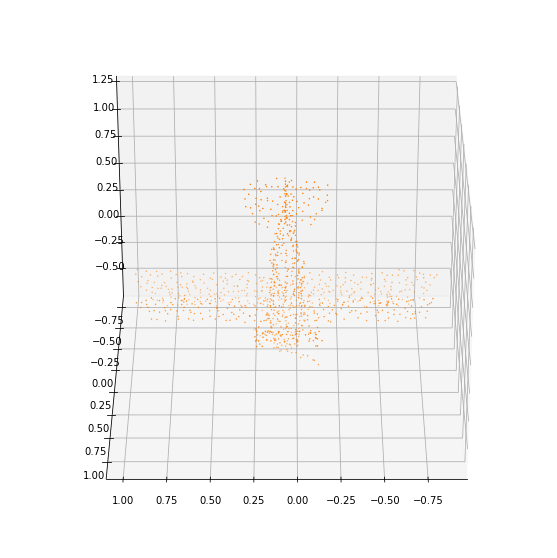

In [8]:
cloud.plot(elev=30)


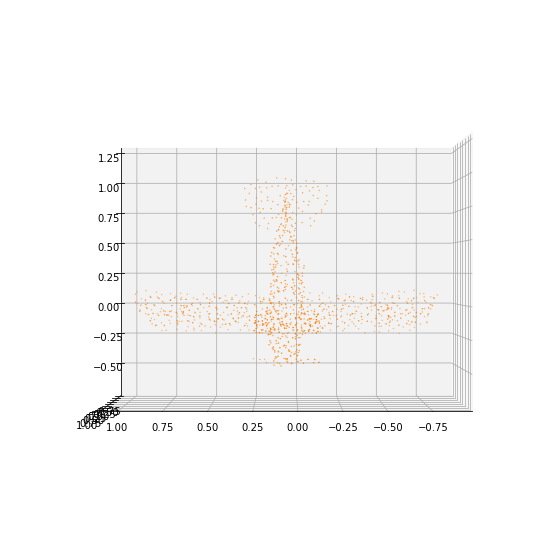

In [9]:
cloud.plot(elev=0)

In [ ]:
!ls


In [10]:

class FeatureProcess(nn.Module):
    def __init__(self, features=[64, 64, 128, 1024]):
        super(FeatureProcess, self).__init__()
        transform_list = []
        for in_features, out_features in zip(features[:-1], features[1:]):
            transform_list += [torch.nn.Conv1d(in_features, out_features, 1), 
                               nn.BatchNorm1d(out_features), 
                               nn.ReLU(inplace=True)]
        self.feature_mlp = nn.Sequential(*transform_list)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
    
    def forward(self,x):
        return self.max_pool(self.feature_mlp(x))

class MLP(nn.Module):
    def __init__(self, features=[64, 64, 128, 1024], p=0.0):
        super(MLP, self).__init__()
        transform_list = []
        for in_features, out_features in zip(features[:-1], features[1:]):
            transform_list += [torch.nn.Linear(in_features, out_features), 
                               nn.BatchNorm1d(out_features), 
                               nn.Dropout(p=p),
                               nn.ReLU(inplace=True)]
        self.mlp = nn.Sequential(*transform_list)
    
    def forward(self,x):
        return self.mlp(x)
    
class TransformNet(nn.Module):
    def __init__(self, k=3, features=[64,128,1024], mlp=[512,256]):
        super(TransformNet, self).__init__()
        self.feature_process = FeatureProcess([k]+features)
        self.feature_mlp = MLP([features[-1]] + mlp + [k**2])
        
        self.register_buffer("I", torch.eye(k))
        self.k=k

    def forward(self, x):
        x = self.feature_process(x)
        x = x.squeeze()

        transform = self.feature_mlp(x)
        transform = transform.view(-1, self.k, self.k)+self.I
        return transform

class PointNet(nn.Module):
    def __init__(self, input_transform=False, feature_transform=False, in_feature_dim=64, features=[64,128,1024]):
        super(PointNet, self).__init__()
        
        self.input_transform = TransformNet(k=3) if input_transform else None
        self.feature_extractor = nn.Sequential(torch.nn.Conv1d(3, in_feature_dim, 1), 
                                 nn.BatchNorm1d(in_feature_dim), 
                                 nn.ReLU(inplace=True),
                                 torch.nn.Conv1d(in_feature_dim, in_feature_dim, 1), 
                                 nn.BatchNorm1d(in_feature_dim), 
                                 nn.ReLU(inplace=True))
        self.feature_transform = TransformNet(k=in_feature_dim) if feature_transform else None
        self.feature_mlp = FeatureProcess([in_feature_dim] + features)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
    
    def forward(self,point_cloud):
        if self.input_transform is not None:
            transform = self.input_transform(point_cloud)
            point_cloud = torch.matmul(transform, point_cloud)
        features = self.feature_extractor(point_cloud)
        if self.feature_transform is not None:
            transform = self.feature_transform(features)
            features = torch.matmul(transform, features)
        output = self.feature_mlp(features)
        pooled_output = self.max_pool(output)

        return pooled_output.squeeze()
    
class PointNetClassifier(nn.Module):
    def __init__(self, input_transform=False, feature_transform=False, in_feature_dim=64, features=[64,128,1024], 
                 mlp_dim=[512, 256], p=0.3, num_classes=40):
        super(PointNetClassifier, self).__init__()
        
        self.point_net = PointNet(input_transform,feature_transform,in_feature_dim,features)
        self.mlp = MLP([features[-1]] + mlp_dim, p=p)
        self.fc = nn.Linear(mlp_dim[-1], num_classes)

    def forward(self, pc):
        xyz, features = pc[..., 0:3].contiguous(), pc[..., 3:].transpose(1, 2).contiguous() if pc.size(-1) > 3 else None
        xyz = xyz.transpose(-1,-2).contiguous()
        xyz = self.point_net(xyz)
        xyz = self.mlp(xyz)
        return self.fc(xyz)

In [11]:

def correct(output, target, topk=(1,)):
    """Computes the correct@k for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t().type_as(target)
    corr = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = corr[:k].flatten().float().sum(0).item()
        res.append(correct_k)
    return res

In [12]:
def run_epoch(model, criterion, optimizer, loader, device, writer, experiment_name, epoch, iteration, train=False):
    total_loss = 0
    correct1 = 0
    mode = 'train' if train else 'val'
    if train:
        model.train()
    else:
        model.eval()
    with torch.set_grad_enabled(train):
        for batch_index, (x, y) in enumerate(tqdm(loader)):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(torch.softmax(pred, dim=1), y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            corr = correct(pred, y)
            correct1 += corr[0]

            writer.add_scalars(f'batch/{mode}_loss', {experiment_name: loss.item()}, iteration)
            writer.add_scalars(f'batch/{mode}_top1', {experiment_name: corr[0] / x.shape[0]},
                               iteration)
            iteration += 1
    total_loss /= len(loader)
    writer.add_scalars('epoch/loss', {experiment_name + f'_{mode}': total_loss}, epoch)
    writer.add_scalars('epoch/top1', {experiment_name + f'_{mode}': correct1 / len(loader.sampler)}, epoch)
    return iteration, correct1 / len(loader.sampler)

In [13]:
model = PointNetClassifier(False, False)
criterion = nn.CrossEntropyLoss()

device = 'cuda:0'


model, criterion = model.to(device), criterion.to(device)

lr = 5e-4
weight_decay = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


In [14]:
import os

from torch.utils.tensorboard import SummaryWriter

train_it, val_it = 0, 0
experiment_name = 'pointnet'

save_path = './results/pointnet'
os.makedirs(save_path, exist_ok=True)

writer = SummaryWriter(log_dir=save_path)



In [15]:
for epoch in trange(8):
    train_it, train_acc = run_epoch(model, criterion, optimizer, train_loader, device, writer, experiment_name, epoch, train_it, train=True)
    val_it, val_acc = run_epoch(model, criterion, optimizer, val_loader, device, writer, experiment_name, epoch, val_it, train=False)
    tqdm.write("Epoch {}: Train acc {:.4f}%, Val acc {:.4f}%".format(epoch, train_acc*100, val_acc*100))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Train acc 23.7021%, Val acc 10.8995%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train acc 37.1939%, Val acc 28.8088%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train acc 43.3709%, Val acc 32.4554%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Train acc 45.2098%, Val acc 26.8639%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: Train acc 46.4696%, Val acc 29.2139%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: Train acc 47.9935%, Val acc 41.5316%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: Train acc 49.7409%, Val acc 41.4911%


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: Train acc 49.9949%, Val acc 37.6823%


### PointNet++
In a follow up work, the PointNet architecture was improved by taking into account local neighbourhoods.

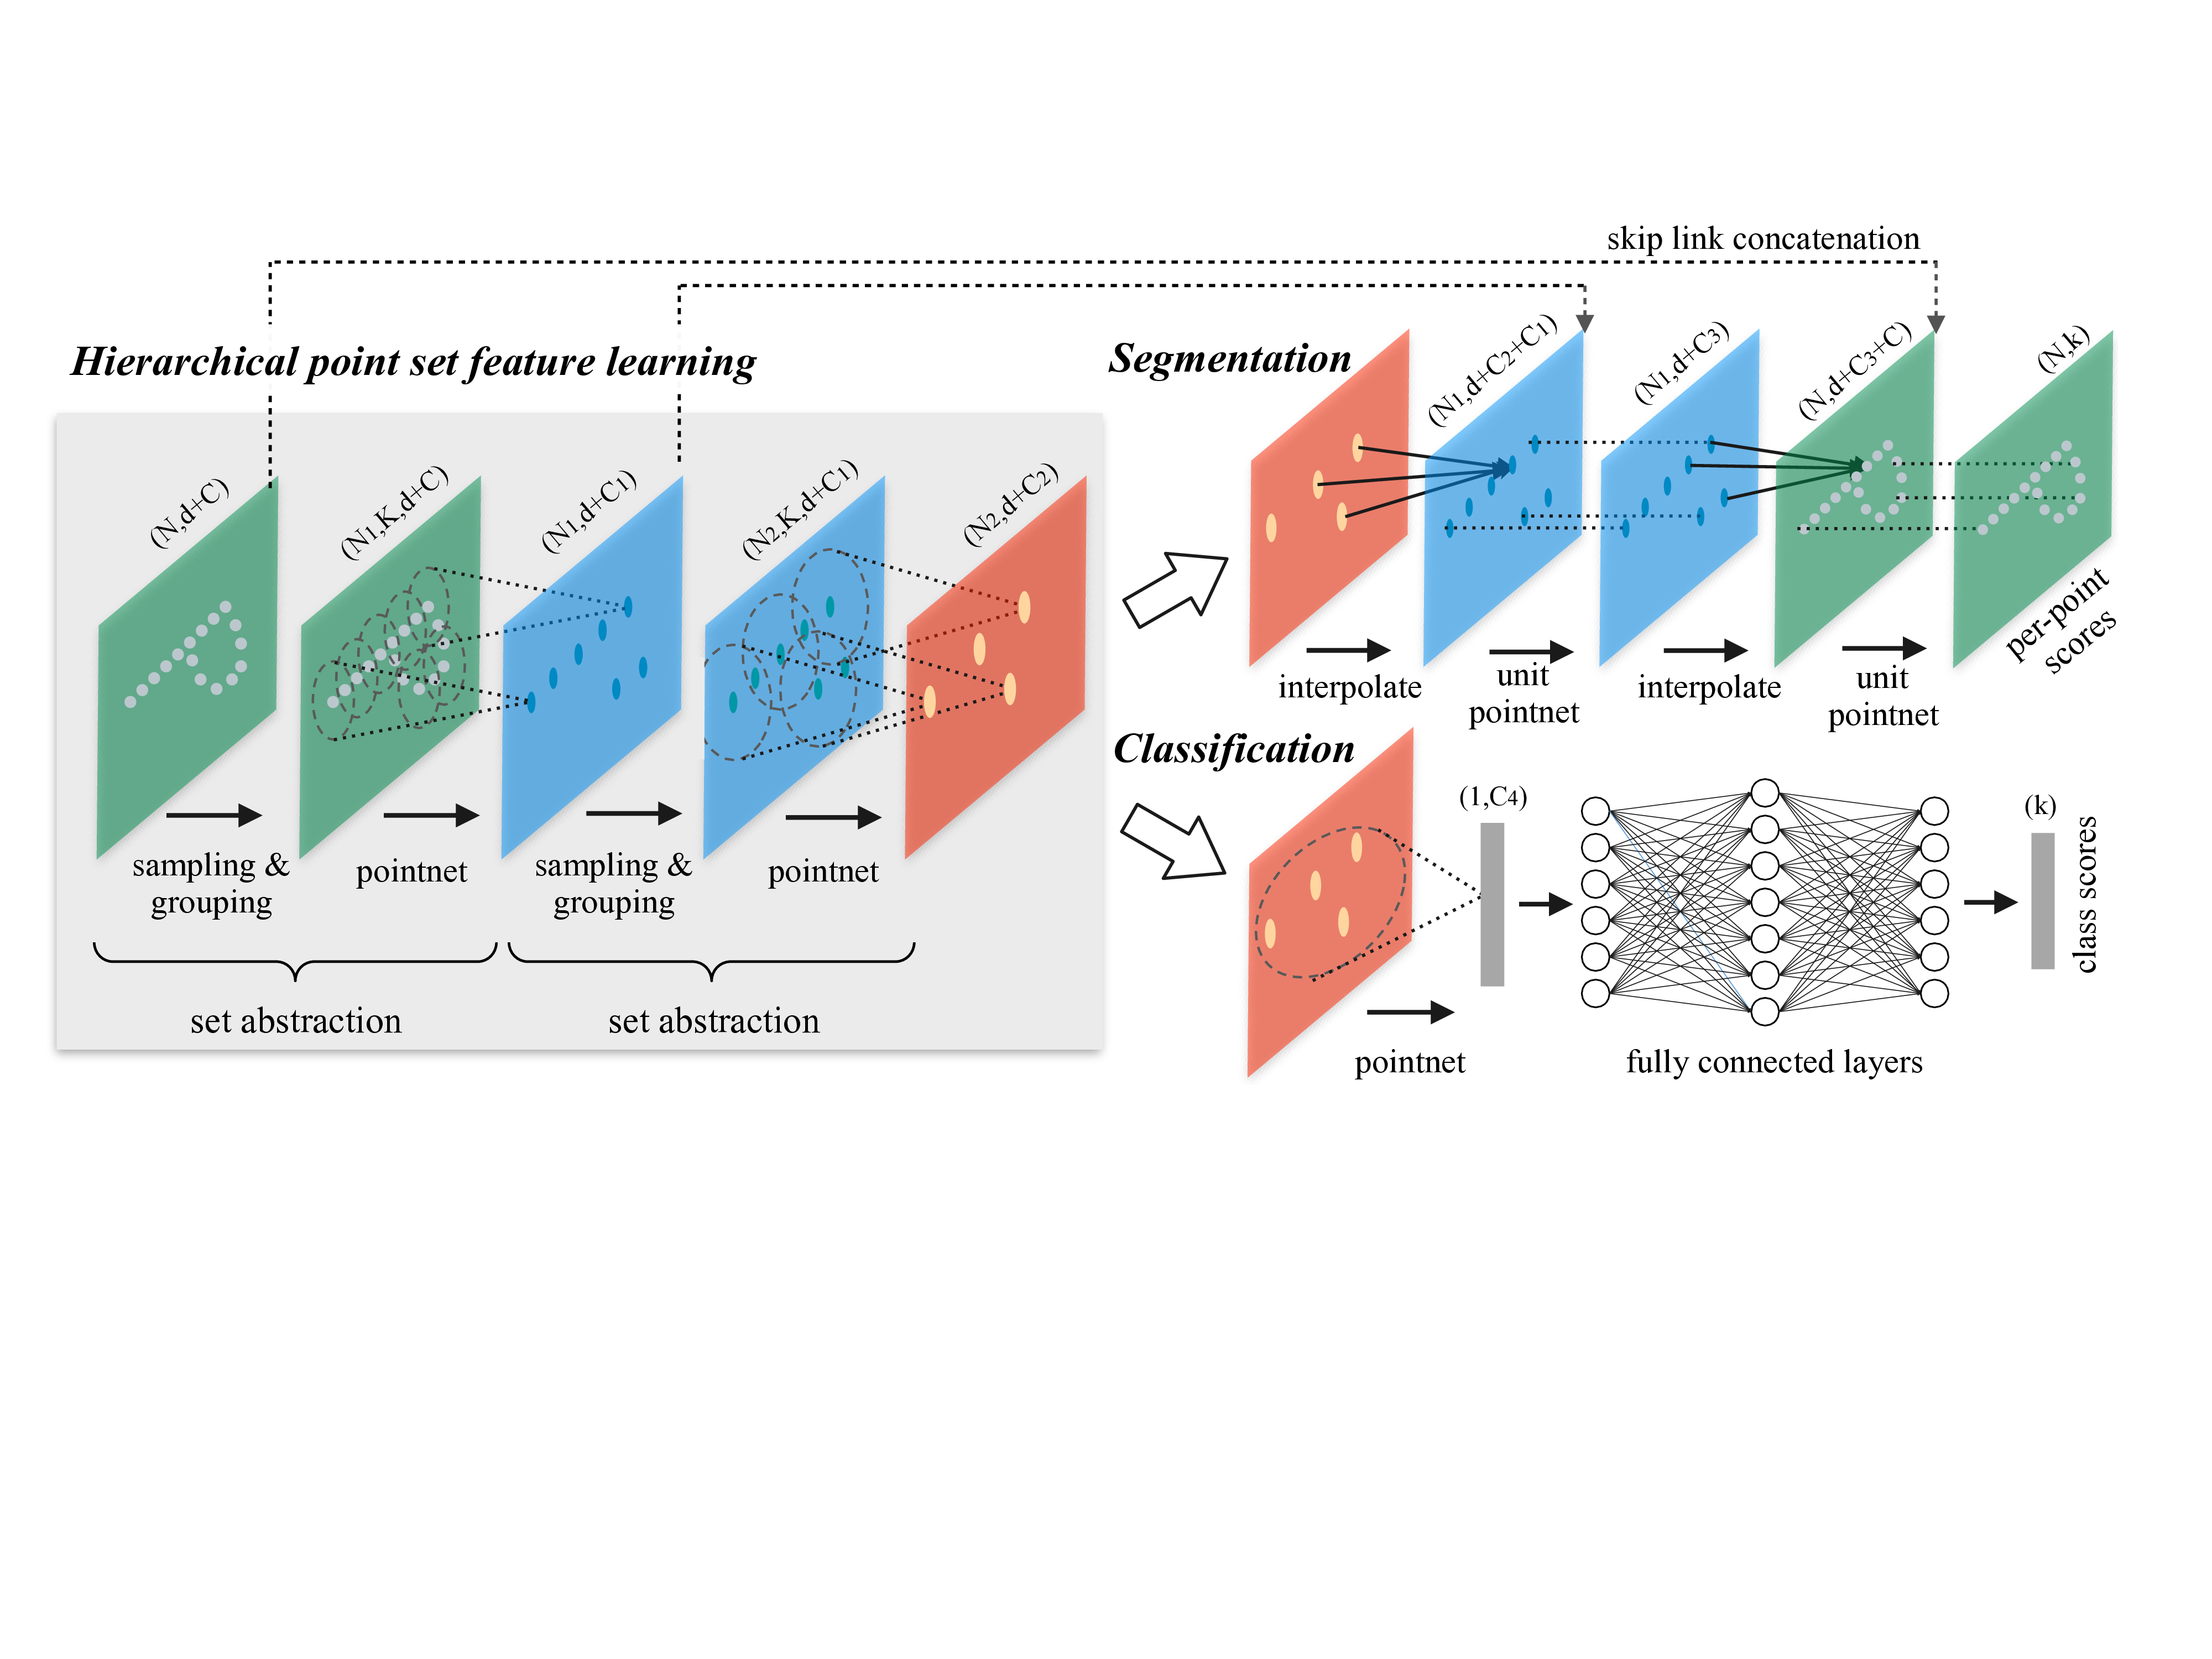

In [16]:
from wand.image import Image as WImage
img = WImage(filename='figures/pnpp.pdf', resolution=400)
img

In [17]:
from pointnet2_ops.pointnet2_modules import PointnetFPModule, PointnetSAModule

class PointNet2SSG(nn.Module):
    def __init__(self, use_xyz=True):
        super().__init__()

        self.SA_modules = nn.ModuleList()
        self.SA_modules.append(
            PointnetSAModule(
                npoint=512,
                radius=0.2,
                nsample=64,
                mlp=[3, 64, 64, 128],
                use_xyz=use_xyz,
            )
        )
        self.SA_modules.append(
            PointnetSAModule(
                npoint=128,
                radius=0.4,
                nsample=64,
                mlp=[128, 128, 128, 256],
                use_xyz=use_xyz,
            )
        )
        self.SA_modules.append(
            PointnetSAModule(
                mlp=[256, 256, 512, 1024], use_xyz=use_xyz
            )
        )

    def forward(self, pc):
        r"""
            Forward pass of the network
            Parameters
            ----------
            pointcloud: Variable(torch.cuda.FloatTensor)
                (B, N, 3 + input_channels) tensor
                Point cloud to run predicts on
                Each point in the point-cloud MUST
                be formated as (x, y, z, features...)
        """
        xyz, features = pc[..., 0:3].contiguous(), pc[..., 3:].transpose(1, 2).contiguous() if pc.size(-1) > 3 else None

        for module in self.SA_modules:
            xyz, features = module(xyz, features)

        return xyz, features.squeeze(-1)
class PointNet2Classifier(nn.Module):
    def __init__(self, use_xyz=True):
        super().__init__()

        self.point_net = PointNet2SSG(use_xyz)

        self.fc_layer = nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 40),
        )

    def forward(self, pointcloud):
        xyz, features = self.point_net(pointcloud)

        return self.fc_layer(features)

In [18]:
del model

In [20]:

batch_size = 64
workers = 8

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, num_workers=workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, num_workers=workers, shuffle=False)

In [21]:
model2 = PointNet2Classifier()
criterion = nn.CrossEntropyLoss()

device = 'cuda:0'

experiment_name = 'pointnet2'

model2, criterion = model2.to(device), criterion.to(device)

lr = 5e-4
weight_decay = 1e-5
optimizer = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
for epoch in trange(5):
    train_it, train_acc = run_epoch(model2, criterion, optimizer, train_loader, device, writer, experiment_name, epoch, train_it, train=True)
    val_it, val_acc = run_epoch(model2, criterion, optimizer, val_loader, device, writer, experiment_name, epoch, val_it, train=False)
    tqdm.write("Train acc {:.4f}%, Val acc {:.4f}%".format(train_acc*100, val_acc*100))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train acc 37.7832%, Val acc 34.0762%


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train acc 45.5552%, Val acc 35.0891%


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train acc 49.4463%, Val acc 44.8541%


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train acc 53.4492%, Val acc 45.1378%


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train acc 56.3141%, Val acc 50.3241%


## MinkowskiNet and sparse convolutions
Working with unstructured permutation-invariant data is pretty complicated and limiting. Instead, we'd love to use something similar to convolutions. However, in 3D convolutions are very computationally inefficient. MinkowskiNet proposed efficient implementation of sparse multi-dimensional convolutions. 
In particular, that allows to uiutilize significant experience of designing convolutional NNs.

In [23]:
# https://github.com/NVIDIA/MinkowskiEngine/blob/master/examples/classification_modelnet40.py
import MinkowskiEngine as ME

class MinkowskiFCNN(ME.MinkowskiNetwork):
    def __init__(
        self,
        in_channel,
        out_channel,
        embedding_channel=1024,
        channels=(32, 48, 64, 96, 128),
        D=3,
    ):
        ME.MinkowskiNetwork.__init__(self, D)

        self.network_initialization(
            in_channel,
            out_channel,
            channels=channels,
            embedding_channel=embedding_channel,
            kernel_size=3,
            D=D,
        )
        self.weight_initialization()

    def get_mlp_block(self, in_channel, out_channel):
        return nn.Sequential(
            ME.MinkowskiLinear(in_channel, out_channel, bias=False),
            ME.MinkowskiBatchNorm(out_channel),
            ME.MinkowskiLeakyReLU(),
        )

    def get_conv_block(self, in_channel, out_channel, kernel_size, stride):
        return nn.Sequential(
            ME.MinkowskiConvolution(
                in_channel,
                out_channel,
                kernel_size=kernel_size,
                stride=stride,
                dimension=self.D,
            ),
            ME.MinkowskiBatchNorm(out_channel),
            ME.MinkowskiLeakyReLU(),
        )

    def network_initialization(
        self,
        in_channel,
        out_channel,
        channels,
        embedding_channel,
        kernel_size,
        D=3,
    ):
        self.mlp1 = self.get_mlp_block(in_channel, channels[0])
        self.conv1 = self.get_conv_block(
            channels[0],
            channels[1],
            kernel_size=kernel_size,
            stride=1,
        )
        self.conv2 = self.get_conv_block(
            channels[1],
            channels[2],
            kernel_size=kernel_size,
            stride=2,
        )

        self.conv3 = self.get_conv_block(
            channels[2],
            channels[3],
            kernel_size=kernel_size,
            stride=2,
        )

        self.conv4 = self.get_conv_block(
            channels[3],
            channels[4],
            kernel_size=kernel_size,
            stride=2,
        )
        self.conv5 = nn.Sequential(
            self.get_conv_block(
                channels[1] + channels[2] + channels[3] + channels[4],
                embedding_channel // 4,
                kernel_size=3,
                stride=2,
            ),
            self.get_conv_block(
                embedding_channel // 4,
                embedding_channel // 2,
                kernel_size=3,
                stride=2,
            ),
            self.get_conv_block(
                embedding_channel // 2,
                embedding_channel,
                kernel_size=3,
                stride=2,
            ),
        )

        self.pool = ME.MinkowskiMaxPooling(kernel_size=3, stride=2, dimension=D)

        self.global_max_pool = ME.MinkowskiGlobalMaxPooling()
        self.global_avg_pool = ME.MinkowskiGlobalAvgPooling()

        self.final = nn.Sequential(
            self.get_mlp_block(embedding_channel * 2, 512),
            ME.MinkowskiDropout(),
            self.get_mlp_block(512, 512),
            ME.MinkowskiLinear(512, out_channel, bias=True),
        )

        # No, Dropout, last 256 linear, AVG_POOLING 92%

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, ME.MinkowskiConvolution):
                ME.utils.kaiming_normal_(m.kernel, mode="fan_out", nonlinearity="relu")

            if isinstance(m, ME.MinkowskiBatchNorm):
                nn.init.constant_(m.bn.weight, 1)
                nn.init.constant_(m.bn.bias, 0)

    def forward(self, x: ME.TensorField):
        x = self.mlp1(x)
        y = x.sparse()

        y = self.conv1(y)
        y1 = self.pool(y)

        y = self.conv2(y1)
        y2 = self.pool(y)

        y = self.conv3(y2)
        y3 = self.pool(y)

        y = self.conv4(y3)
        y4 = self.pool(y)

        x1 = y1.slice(x)
        x2 = y2.slice(x)
        x3 = y3.slice(x)
        x4 = y4.slice(x)

        x = ME.cat(x1, x2, x3, x4)

        y = self.conv5(x.sparse())
        x1 = self.global_max_pool(y)
        x2 = self.global_avg_pool(y)

        return self.final(ME.cat(x1, x2)).F

/home/evgeniizh/.conda/envs/tut5_4/lib/python3.9/site-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [24]:

def minkowski_collate_fn(list_data):
    coo, features, label = [x[0][...,0:3] for x in list_data],[x[0][...,3:] for x in list_data],[x[1]  for x in list_data]
    
    coordinates_batch, features_batch, labels_batch = ME.utils.sparse_collate(
        coo,
        features,
        label,
        dtype=torch.float32,
    )
    return {
        "coordinates": coordinates_batch,
        "features": features_batch,
        "labels": labels_batch,
    }


In [25]:


def create_input_batch(batch, device="cuda", quantization_size=0.05):
    batch["coordinates"][:, 1:] = batch["coordinates"][:, 1:] / quantization_size
    return ME.TensorField(
            coordinates=batch["coordinates"],
            features=batch["features"],
            device=device,
        )

def run_epoch(model, criterion, optimizer, loader, device, writer, experiment_name, epoch, iteration, train=False):
    total_loss = 0
    correct1 = 0
    mode = 'train' if train else 'val'
    if train:
        model.train()
    else:
        model.eval()
    with torch.set_grad_enabled(train):
        for batch_index, data_dict in enumerate(tqdm(loader)):
            inp = create_input_batch(
            data_dict, device=device, quantization_size=0.05
            )
            pred = model(inp)
            y = torch.tensor(data_dict["labels"]).to(device)
            loss = criterion(torch.softmax(pred, dim=1), y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            corr = correct(pred, y)
            correct1 += corr[0]

            writer.add_scalars(f'batch/{mode}_loss', {experiment_name: loss.item()}, iteration)
            writer.add_scalars(f'batch/{mode}_top1', {experiment_name: corr[0] / x.shape[0]},
                               iteration)
            iteration += 1
    total_loss /= len(loader)
    writer.add_scalars('epoch/loss', {experiment_name + f'_{mode}': total_loss}, epoch)
    writer.add_scalars('epoch/top1', {experiment_name + f'_{mode}': correct1 / len(loader.sampler)}, epoch)
    return iteration, correct1 / len(loader.sampler)

In [26]:
batch_size=4
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, num_workers=workers, collate_fn=minkowski_collate_fn,  shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, num_workers=workers, collate_fn=minkowski_collate_fn,  shuffle=False)

In [27]:
del model2

In [ ]:
model3 = MinkowskiFCNN(in_channel=3, out_channel=40, embedding_channel=1024)
criterion = nn.CrossEntropyLoss()

device = 'cuda:0'

experiment_name = 'minkowski'

model3, criterion = model3.to(device), criterion.to(device)

lr = 1e-6
weight_decay = 1e-5
optimizer = torch.optim.AdamW(model3.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
for epoch in trange(50):
    train_it, train_acc = run_epoch(model3, criterion, optimizer, train_loader, device, writer, experiment_name, epoch, train_it, train=True)
    val_it, val_acc = run_epoch(model3, criterion, optimizer, val_loader, device, writer, experiment_name, epoch, val_it, train=False)
    tqdm.write("Train acc {:.4f}%, Val acc {:.4f}%".format(train_acc*100, val_acc*100))

## PointContrast
Similarly to 2D case, self-supervised pre-training is possible in 3D case.